In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

## Data

The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe (1/0) a term deposit (variable y).

This dataset provides the customer information. It includes 41188 records and 21 fields.

In [24]:
### Q. Read the bank dataset 
data = pd.read_csv("bank.csv", sep=';')

In [25]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


#### Input variables

1 - age (numeric)

2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')

3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)

4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')

5 - default: has credit in default? (categorical: 'no','yes','unknown')

6 - housing: has housing loan? (categorical: 'no','yes','unknown')

7 - loan: has personal loan? (categorical: 'no','yes','unknown')

8 - contact: contact communication type (categorical: 'cellular','telephone')

9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')

11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

14 - previous: number of contacts performed before this campaign and for this client (numeric)

15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

16 - emp.var.rate: employment variation rate - (numeric)

17 - cons.price.idx: consumer price index - (numeric)

18 - cons.conf.idx: consumer confidence index - (numeric) 

19 - euribor3m: euribor 3 month rate - (numeric)

20 - nr.employed: number of employees - (numeric)

#### Predict variable (desired target):

y - has the client subscribed a term deposit? (binary: '1','0')

The education column of the dataset has many categories and we need to reduce the categories for a better modelling. The education column has the following categories:

In [26]:
### Data transformation
data['education'].unique()

array(['basic.9y', 'high.school', 'university.degree',
       'professional.course', 'basic.6y', 'basic.4y', 'unknown',
       'illiterate'], dtype=object)

Let us group "basic.4y", "basic.9y" and "basic.6y" together and call them "basic".

In [27]:
data['education']=np.where(data['education'] =='basic.9y', 'Basic', data['education'])
data['education']=np.where(data['education'] =='basic.6y', 'Basic', data['education'])
data['education']=np.where(data['education'] =='basic.4y', 'Basic', data['education'])

After grouping, this is the columns

In [28]:
data['education'].unique()

array(['Basic', 'high.school', 'university.degree', 'professional.course',
       'unknown', 'illiterate'], dtype=object)

### Data exploration

no     3668
yes     451
Name: y, dtype: int64


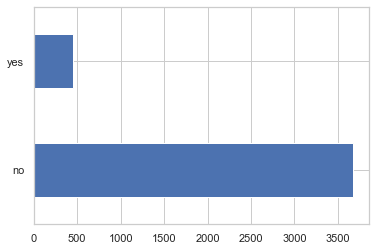

In [29]:
### Q. Find out in the target column what is the respective count of values
print(data['y'].value_counts())
### Q. Also plot the values of y in form of a bar graph
data['y'].value_counts().plot(kind='barh')

Let's get a sense of the numbers across the two classes

In [13]:
## Q. find the average of the remaining variables by different values of 'y'
means = data.groupby('y').mean()
means.head()

## Q. Mention the key findings out of the previous split

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
y,,,,,,,,,,
no,39.895311,219.40976,2.605780,982.763086,0.141767,0.240185,93.599677,-40.586723,3.802826,5175.502072
yes,41.889135,560.78714,1.980044,778.722838,0.585366,-1.177384,93.417268,-39.786475,2.145448,5093.118625


Observations:

The average age of customers who bought the term deposit is higher than that of the customers who didn't.
The pdays (days since the customer was last contacted) is understandably lower for the customers who bought it. The lower the pdays, the better the memory of the last call and hence the better chances of a sale.
Surprisingly, campaigns (number of contacts or calls made during the current campaign) are lower for customers who bought the term deposit.

We can calculate categorical means for other categorical variables such as education and marital status to get a more detailed sense of our data.

In [15]:
### Find the mean of other variables by different values of 'job' variable
means = data.groupby('job').mean()
means

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
job,,,,,,,,,,
admin.,38.240119,261.871542,2.642292,944.025692,0.192688,0.061462,93.527008,-40.014723,3.601909,5165.542885
blue-collar,39.265837,261.852941,2.432127,983.270362,0.147059,0.235520,93.669430,-41.571493,3.742370,5174.265611
entrepreneur,42.202703,249.202703,2.216216,992.263514,0.141892,0.263514,93.614682,-40.839865,3.931493,5180.600000
housemaid,45.672727,229.663636,2.463636,980.909091,0.100000,0.426364,93.658536,-39.324545,4.009182,5179.862727
management,42.429012,246.799383,2.432099,953.015432,0.246914,-0.049691,93.483056,-40.591667,3.553451,5165.971914
retired,60.873494,311.789157,2.397590,897.301205,0.325301,-0.580120,93.487506,-39.034337,2.875741,5126.062048
self-employed,40.679245,254.924528,2.817610,967.691824,0.207547,0.086164,93.575283,-40.323899,3.669296,5166.974843
services,38.513995,232.529262,2.844784,978.773537,0.178117,0.067684,93.626059,-41.532061,3.552776,5165.806870
student,26.695122,287.134146,1.951220,902.426829,0.487805,-1.192683,93.448329,-39.665854,2.165354,5092.046341


In [16]:
### Find the mean of other variables by different values of 'marital' variable
means = data.groupby('marital').mean()
means

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
marital,,,,,,,,,,
divorced,45.107623,263.163677,2.542601,972.255605,0.174888,0.143274,93.600547,-40.621973,3.707177,5170.145964
married,42.389398,256.289757,2.527700,964.162216,0.173774,0.172260,93.599039,-40.357114,3.728554,5170.724472
single,33.209020,254.647875,2.555941,947.338248,0.233304,-0.128448,93.529971,-40.768257,3.352657,5155.756114
unknown,42.272727,336.272727,2.545455,999.000000,0.090909,0.181818,93.537545,-39.690909,3.855182,5174.409091


In [17]:
### Find the mean of other variables by different values of 'education' variable
means = data.groupby('education').mean()
means

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
education,,,,,,,,,,
Basic,42.337124,253.898457,2.429732,978.815597,0.149472,0.237368,93.658600,-41.120552,3.775701,5174.133144
high.school,38.097720,258.534202,2.630836,958.022801,0.206298,-0.002497,93.564314,-40.995765,3.511732,5163.212595
illiterate,42.000000,146.000000,4.000000,999.000000,0.000000,-2.900000,92.201000,-31.400000,0.834000,5076.200000
professional.course,40.207477,278.816822,2.512150,958.211215,0.194393,0.163925,93.599630,-40.127664,3.701426,5167.595140
university.degree,39.017405,247.707278,2.583070,947.900316,0.207278,-0.009731,93.499109,-39.830063,3.547132,5163.023180
unknown,42.826347,267.281437,2.538922,939.700599,0.263473,-0.074251,93.637455,-39.487425,3.410174,5151.260479


Visualizations

Text(0, 0.5, 'Purchase frequency')

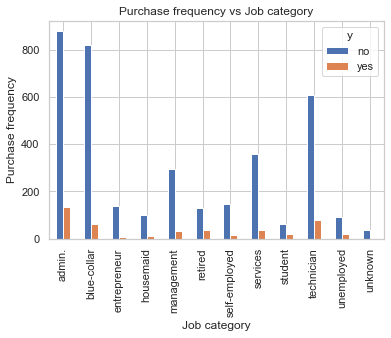

In [76]:
## Create a visualization as shown below for variable 'job' and frequency of purchase
data.groupby(['job','y']).size().unstack().plot(kind='bar',stacked=False)
plt.title("Purchase frequency vs Job category")
plt.xlabel("Job category")
plt.ylabel("Purchase frequency")

The frequency of purchase of the deposit depends a great deal on the job title. Thus, the job title can be a good predictor of the outcome variable.

Text(0, 0.5, 'Purchase frequency')

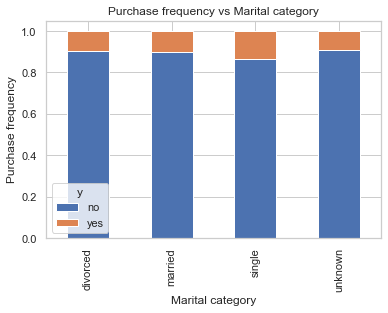

In [93]:
### Create a stacked bar chart between variables 'Marital Status','Purchase' and Proportion of Customers
(data.groupby(['marital','y']).size() / data.groupby(['marital']).size()).unstack().plot(kind='bar',stacked=True)
plt.title("Purchase frequency vs Marital category")
plt.xlabel("Marital category")
plt.ylabel("Purchase frequency")

Hard to see, but the marital status does not seem a strong predictor for the outcome variable.

Text(0, 0.5, 'Purchase frequency')

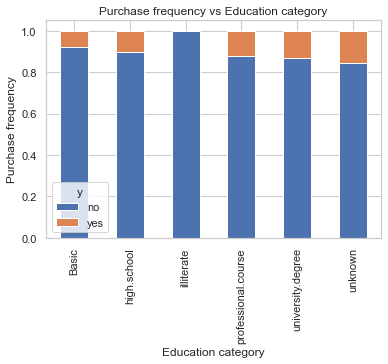

In [95]:
### Create a stacked bar chart between variables 'Education','Purchase' and Proportion of Customers
(data.groupby(['education','y']).size() / data.groupby(['education']).size()).unstack().plot(kind='bar',stacked=True)
plt.title("Purchase frequency vs Education category")
plt.xlabel("Education category")
plt.ylabel("Purchase frequency")


Education seems a good predictor of the outcome variable.

Text(0, 0.5, 'Purchase frequency')

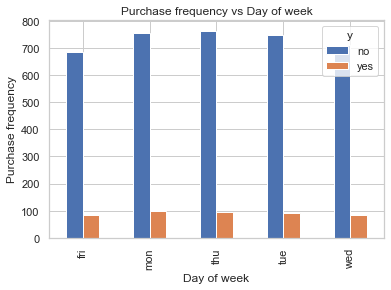

In [96]:
### Create a stacked bar chart between variables 'day_of_week' and Proportion of Customers grouped by variable 'y'
data.groupby(['day_of_week','y']).size().unstack().plot(kind='bar',stacked=False)
plt.title("Purchase frequency vs Day of week")
plt.xlabel("Day of week")
plt.ylabel("Purchase frequency")

Day of week may not be a good predictor of the outcome

Text(0, 0.5, 'Purchase frequency')

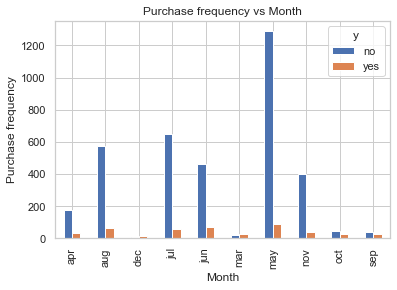

In [97]:
## Q. Write code for the visualization as shown below
data.groupby(['month','y']).size().unstack().plot(kind='bar',stacked=False)
plt.title("Purchase frequency vs Month")
plt.xlabel("Month")
plt.ylabel("Purchase frequency")

Month might be a good predictor of the outcome variable

Text(0, 0.5, 'Purchase frequency')

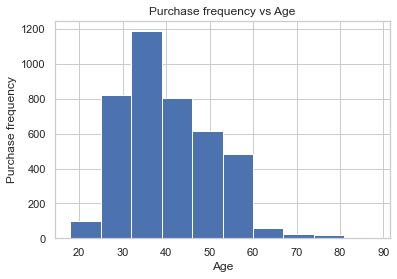

In [99]:
## Q. Write code for the visualization as shown below
data['age'].hist()
plt.title("Purchase frequency vs Age")
plt.xlabel("Age")
plt.ylabel("Purchase frequency")

The most of the customers of the bank in this dataset are in the age range of 30-40.

Text(0, 0.5, 'Purchase frequency')

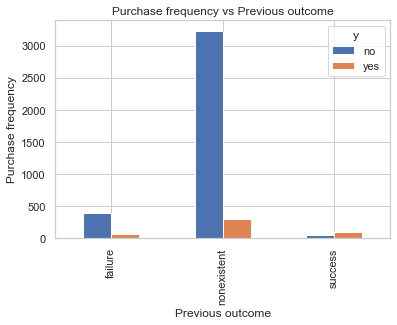

In [100]:
## Q. Write code for the visualization as shown below
data.groupby(['poutcome','y']).size().unstack().plot(kind='bar',stacked=False)
plt.title("Purchase frequency vs Previous outcome")
plt.xlabel("Previous outcome")
plt.ylabel("Purchase frequency")

Poutcome seems to be a good predictor of the outcome variable.

### Create dummy variables

In [138]:
## Write code to convert following columns to equivalent dummy variables
categories = ['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
data_final = pd.get_dummies(data, columns = categories, drop_first=True)
data_final.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,30,487,2,999,0,-1.8,92.893,-46.2,1.313,5099.1,...,1,0,0,0,0,0,0,0,1,0
1,39,346,4,999,0,1.1,93.994,-36.4,4.855,5191.0,...,1,0,0,0,0,0,0,0,1,0
2,25,227,1,999,0,1.4,94.465,-41.8,4.962,5228.1,...,0,0,0,0,0,0,0,1,1,0
3,38,17,3,999,0,1.4,94.465,-41.8,4.959,5228.1,...,0,0,0,0,0,0,0,0,1,0
4,47,58,1,999,0,-0.1,93.200,-42.0,4.191,5195.8,...,0,1,0,0,1,0,0,0,1,0


In [149]:
data_final_vars=data_final.columns.values.tolist()
y=['y']
X=[i for i in data_final_vars if i not in y]
print(len(X), X)

51 ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_married', 'marital_single', 'marital_unknown', 'education_high.school', 'education_illiterate', 'education_professional.course', 'education_university.degree', 'education_unknown', 'default_unknown', 'default_yes', 'housing_unknown', 'housing_yes', 'loan_unknown', 'loan_yes', 'contact_telephone', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed', 'poutcome_nonexistent', 'poutcome_success']


### Feature Selection

In [151]:
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=5000)

rfe = RFE(estimator=logreg, n_features_to_select=18)
rfe = rfe.fit(data_final[X], data_final.y)
print(rfe.support_)
print(rfe.ranking_)

[False False False False  True  True  True False False False  True  True
 False  True False  True  True False False False  True False False False
 False False False False False False False  True False False False  True
  True  True False False  True  True  True False False False False False
 False  True  True]
[25 31 17 33  1  1  1 20 28 27  1  1 19  1 11  1  1 16 26 10  1 14 15 30
 29  6 12 13  7 24 34  1  9  8 18  1  1  1 22  3  1  1  1  5  4 21 23 32
  2  1  1]


The Recursive Feature Elimination (RFE) helps us select the most important features.

In [152]:
features=[X[i] for i in range(len(X)) if rfe.support_[i] & (X[i] not in y)]
print('Selected features => ', features)
X=data_final[features]
y=data_final['y']

Selected features =>  ['previous', 'emp.var.rate', 'cons.price.idx', 'job_blue-collar', 'job_entrepreneur', 'job_management', 'job_self-employed', 'job_services', 'job_unknown', 'housing_unknown', 'contact_telephone', 'month_aug', 'month_dec', 'month_mar', 'month_may', 'month_nov', 'poutcome_nonexistent', 'poutcome_success']


### Logistic Regression Model Fitting

In [165]:
## Write code to import Logistic Regression module from SKlearn library and train the X,Y variables on that Logistic Regression object
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

model = LogisticRegression(max_iter=5000)
model.fit(X_train,y_train)

LogisticRegression(max_iter=5000)

#### Predicting the test set results and caculating the accuracy

In [167]:
## Perform predictions on the Test dataset
predictions = model.predict(X_test)

In [170]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(model.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.91


### Cross Validation

In [172]:
## Write down code for a 10 fold cross validation on the given X,Y variables
from sklearn.model_selection import cross_val_score

print(cross_val_score(model, X_train, y_train, cv=10))

[0.88181818 0.90606061 0.87878788 0.9030303  0.89393939 0.90881459
 0.90273556 0.91489362 0.88145897 0.89361702]


### Confusion Matrix

In [169]:
## Create the confusion matrix
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, predictions))

[[736  12]
 [ 60  16]]


The result is telling us that we have 736+16 correct predictions and 60+12 incorrect predictions.

#### Accuracy

In [161]:
## Find the accuracy of your model
from sklearn.metrics import accuracy_score

print('Accuracy = ', accuracy_score(y_test, predictions))

Accuracy =  0.912621359223301


#### Compute precision, recall, F-measure and support

The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.

The F-beta score weights recall more than precision by a factor of beta. beta == 1.0 means recall and precision are equally important.

The support is the number of occurrences of each class in y_test.

In [157]:
from sklearn.metrics import classification_report

print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

          no       0.92      0.98      0.95       748
         yes       0.57      0.21      0.31        76

    accuracy                           0.91       824
   macro avg       0.75      0.60      0.63       824
weighted avg       0.89      0.91      0.89       824



#### Interpretation: 

Of the entire test set, 89% of the promoted term deposit were the term deposit that the customers liked. Of the entire test set, 91% of the customer's preferred term deposit were promoted.

### ROC Curve

ROC AUC=0.767


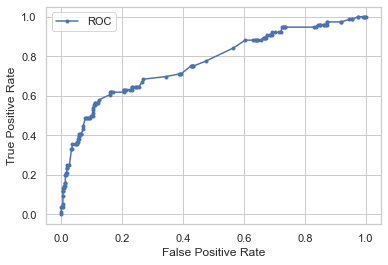

In [178]:
## Draw ROC curve for your model
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# predict probabilities
probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate scores
auc = roc_auc_score(y_test, probs)
print('ROC AUC=%.3f' % (auc))
# calculate roc curve
fpr, tpr, _ = roc_curve(y_test, probs, pos_label='yes')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.', label='ROC')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()